In [1]:
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation, Reshape, Input, Embedding, LSTM, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model, load_model
from keras.utils  import to_categorical
from datetime     import datetime
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

Using TensorFlow backend.


In [2]:
data_dir = 'numpy_arrays'
X  = 'train_picture_features.npy'
y  = 'train_picture_labels.npy'

train_features = np.load(os.path.join(data_dir, X))
train_labels   = np.load(os.path.join(data_dir, y))

print("Features:",train_features.shape)
print("Labels", train_labels.shape)

Features: (33402,)
Labels (33402,)


In [3]:
# Preprocessing features
from skimage.transform import resize

%matplotlib inline

def resize_images(arrays, side_length):
    
    array_count = arrays.shape[0]
    template    = np.zeros((side_length, side_length,3))
    all_arrays = []
    
    for array in arrays:
        
        #print(array.shape)
        height, width = array.shape[0], array.shape[1]
        if height > width:
            new_height = side_length
            diff       = side_length / height
            new_width  = width * diff
        else:
            new_width  = side_length
            diff       = side_length / width
            new_height = height * diff
            
            tmp            = resize(array, (int(new_height), int(new_width), 3), mode='constant')
            top_padding    = np.zeros((int((side_length - tmp.shape[0]) / 2), side_length, 3))
            bottom_padding = np.zeros((int(side_length - top_padding.shape[0] - tmp.shape[0]) , side_length, 3))
 
            #print(top_padding.shape)
            #print(tmp.shape)
            #print(bottom_padding.shape)
            final = np.concatenate((top_padding, tmp, bottom_padding))
            #print(final.shape)
        
        all_arrays.append(final)
    
    return np.array(all_arrays)

def crop(arrays, new_width):
    ratio_max = 0.0
    ratio_min = np.inf
    
    for i, array in enumerate(arrays):
        print(array.shape)
        if i > 20:
            break
        height, width = array.shape[0], array.shape[1]
        ratio = height / (1.0 * width)
        ratio_max = max(ratio_max, ratio)
        ratio_min = min(ratio_min, ratio)

    print("MAX: ", ratio_max)
    print("MIN: ", ratio_min)
#################################

def resize_32x32(features):
    return np.array([resize(f, (32, 32, 3), mode='constant') for f in features])

def resize_32x32_grey(features):
    return np.array([resize(f, (32, 32, 1), mode='constant') for f in features])

def resize_64x64(features):
    return np.array([resize(f, (64, 64, 3), mode='constant') for f in features])

resized_images = resize_32x32(train_features)

print(resized_images.shape)
print(type(resized_images))

(33402, 32, 32, 3)
<class 'numpy.ndarray'>


In [4]:
# Preprocessing targets

def list_to_arrays(labels):
    return np.array([np.array(label) for label in labels])

def remove_val(labels, in_val, out_val):
    for label in labels:
        label[label == in_val] = out_val
    
    return labels
    #return np.where(labels==in_val, out_val, labels) 

def pad_labels(train_labels):
    print(train_labels.shape)
    max_len = 0
    
    for arr in train_labels:
        max_len = max(len(arr), max_len)

    print("MAX LENGTH: {}".format(max_len))
    
    return np.array([arr + ((max_len - len(arr)) * [10.0]) for arr in train_labels])     

def one_hot_encoding(labels):
    return np.array([ to_categorical(label, num_classes=11) for label in labels])


train_labels[24] = [6.0, 0.0, 1.0]
print(train_labels[24])
print(train_labels.shape)

padded_labels = pad_labels(train_labels)
print(padded_labels[24])
print(padded_labels.shape)

encoded_labels = one_hot_encoding(padded_labels)
print(encoded_labels[24])
print(encoded_labels.shape)

[6.0, 0.0, 1.0]
(33402,)
(33402,)
MAX LENGTH: 6
[  6.   0.   1.  10.  10.  10.]
(33402, 6)
[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
(33402, 6, 11)


In [6]:
#encoded_labels[:, 6]
tmp = [encoded_labels[:, i] for i in range(encoded_labels.shape[1])]
type(tmp)

#print(padded_labels[0])
#print(encoded_labels[0])
#print(padded_labels[1])
#print(encoded_labels[1])

#tmp = [label[j] for label in encoded_labels for j in range(len(label))]
reordered_array = []
for i in range(encoded_labels.shape[1]):
    tmp = []

    for label in encoded_labels:
        #print(label[i])

        tmp.append(label[i])
    tmp = np.array(tmp)
    reordered_array.append(tmp)
reordered_array = np.array(reordered_array)

print(reordered_array.shape)
#tmp = [i for i in reordered_array]
#print(tmp.shape)

(6, 33402, 11)


In [13]:
features = resized_images
targets = [encoded_labels[:, i] for i in range(6)]
#targets = encoded_labels
#targets = padded_labels
#targets = reordered_array

print("INPUT SHAPE: {}".format(features.shape))

inputs_ = Input(shape=(32,32,3))
x = inputs_

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x) 
x = Dropout(0.25)(x)
"""
x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x) 
x = Dropout(0.25)(x)

x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x) 
x = Dropout(0.25)(x)

x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x) 
x = Dropout(0.25)(x)
"""
###########################################
x = Flatten()(x)
x = Dense(512, activation='relu')(x)

digit1 = Dense(11, activation='softmax')(x)
digit2 = Dense(11, activation='softmax')(x)
digit3 = Dense(11, activation='softmax')(x)
digit4 = Dense(11, activation='softmax')(x)
digit5 = Dense(11, activation='softmax')(x)
digit6 = Dense(11, activation='softmax')(x)

model = Model(input=inputs_, outputs=[digit1, digit2, digit3, digit4, digit5, digit6])
model.summary()

INPUT SHAPE: (33402, 32, 32, 3)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, 32, 32, 32)    896                                          
____________________________________________________________________________________________________
batch_normalization_2 (BatchNorm (None, 32, 32, 32)    128                                          
____________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)   (None, 16, 16, 32)    0                                            
___________________________________________________________

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


In [19]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint

epochs     = 20
time_now   = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = os.path.join('models', 'model_multi_ModelAPI_' + str(epochs) + 'epochs_' + time_now +'.hdf5')

print("MODEL FILE: {}".format(model_path))

checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, save_best_only=True, monitor='acc',)

model.fit(features, targets,
          validation_split=0.25,
          epochs=epochs, 
          batch_size=32, 
          callbacks=[checkpointer], 
          verbose=1)


MODEL FILE: models/model_multi_ModelAPI_20epochs_20190702_021144.hdf5
Train on 25051 samples, validate on 8351 samples
Epoch 1/20
25051/25051 [==============================] - 128s - loss: 11.9794 - dense_16_loss: 4.2639 - dense_17_loss: 4.7592 - dense_18_loss: 2.5060 - dense_19_loss: 0.4465 - dense_20_loss: 0.0039 - dense_21_loss: 1.1921e-07 - dense_16_acc: 0.3457 - dense_17_acc: 0.2858 - dense_18_acc: 0.6877 - dense_19_acc: 0.9549 - dense_20_acc: 0.9998 - dense_21_acc: 1.0000 - val_loss: 27.0716 - val_dense_16_loss: 10.7030 - val_dense_17_loss: 11.5573 - val_dense_18_loss: 4.2111 - val_dense_19_loss: 0.5925 - val_dense_20_loss: 0.0058 - val_dense_21_loss: 0.0019 - val_dense_16_acc: 0.2909 - val_dense_17_acc: 0.1783 - val_dense_18_acc: 0.7331 - val_dense_19_acc: 0.9632 - val_dense_20_acc: 0.9996 - val_dense_21_acc: 0.9999
Epoch 2/20
   32/25051 [..............................] - ETA: 123s - loss: 23.9512 - dense_16_loss: 6.7194 - dense_17_loss: 11.1875 - dense_18_loss: 4.5332 - dense

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:388: RuntimeWarning: Can save best model only with acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


25051/25051 [==============================] - 129s - loss: 27.4444 - dense_16_loss: 10.8049 - dense_17_loss: 11.7587 - dense_18_loss: 4.2850 - dense_19_loss: 0.5919 - dense_20_loss: 0.0039 - dense_21_loss: 1.1921e-07 - dense_16_acc: 0.2933 - dense_17_acc: 0.2507 - dense_18_acc: 0.7337 - dense_19_acc: 0.9633 - dense_20_acc: 0.9998 - dense_21_acc: 1.0000 - val_loss: 28.5090 - val_dense_16_loss: 11.5128 - val_dense_17_loss: 12.1402 - val_dense_18_loss: 4.2558 - val_dense_19_loss: 0.5925 - val_dense_20_loss: 0.0058 - val_dense_21_loss: 0.0019 - val_dense_16_acc: 0.2746 - val_dense_17_acc: 0.2468 - val_dense_18_acc: 0.7360 - val_dense_19_acc: 0.9632 - val_dense_20_acc: 0.9996 - val_dense_21_acc: 0.9999
Epoch 3/20
25051/25051 [==============================] - 135s - loss: 28.4412 - dense_16_loss: 11.5928 - dense_17_loss: 11.9739 - dense_18_loss: 4.2787 - dense_19_loss: 0.5919 - dense_20_loss: 0.0039 - dense_21_loss: 1.1921e-07 - dense_16_acc: 0.2785 - dense_17_acc: 0.2571 - dense_18_acc: 0

25051/25051 [==============================] - 150s - loss: 28.4825 - dense_16_loss: 11.6342 - dense_17_loss: 11.9739 - dense_18_loss: 4.2787 - dense_19_loss: 0.5919 - dense_20_loss: 0.0039 - dense_21_loss: 1.1921e-07 - dense_16_acc: 0.2782 - dense_17_acc: 0.2571 - dense_18_acc: 0.7345 - dense_19_acc: 0.9633 - dense_20_acc: 0.9998 - dense_21_acc: 1.0000 - val_loss: 28.7254 - val_dense_16_loss: 11.7291 - val_dense_17_loss: 12.1402 - val_dense_18_loss: 4.2558 - val_dense_19_loss: 0.5925 - val_dense_20_loss: 0.0058 - val_dense_21_loss: 0.0019 - val_dense_16_acc: 0.2723 - val_dense_17_acc: 0.2468 - val_dense_18_acc: 0.7360 - val_dense_19_acc: 0.9632 - val_dense_20_acc: 0.9996 - val_dense_21_acc: 0.9999
Epoch 14/20
25051/25051 [==============================] - 146s - loss: 28.4627 - dense_16_loss: 11.6143 - dense_17_loss: 11.9739 - dense_18_loss: 4.2787 - dense_19_loss: 0.5919 - dense_20_loss: 0.0039 - dense_21_loss: 1.1921e-07 - dense_16_acc: 0.2789 - dense_17_acc: 0.2571 - dense_18_acc: 

PREDICTION0: [  1.  10.  10.  10.  10.  10.]
PREDICTION1: [  1.  10.  10.  10.  10.  10.]
PREDICTION2: [  1.  10.  10.  10.  10.  10.]
PREDICTION3: [  1.  10.  10.  10.  10.  10.]
PREDICTION4: [  1.  10.  10.  10.  10.  10.]
LABEL0: [  1.   9.  10.  10.  10.  10.]
LABEL1: [  2.   3.  10.  10.  10.  10.]
LABEL2: [  2.   5.  10.  10.  10.  10.]
LABEL3: [  9.   3.  10.  10.  10.  10.]
LABEL4: [  3.   1.  10.  10.  10.  10.]


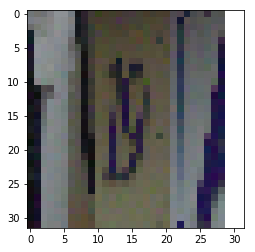

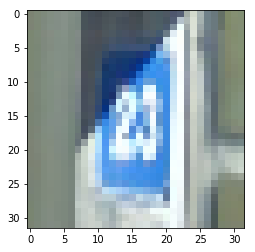

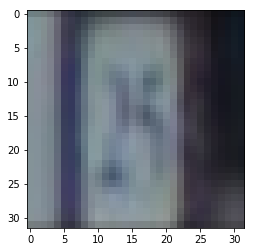

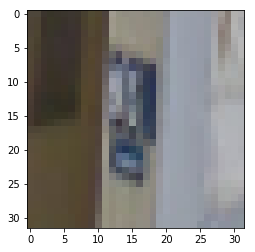

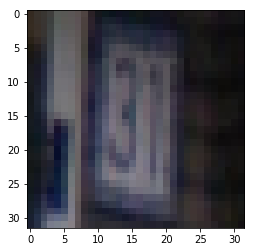

In [29]:
# TESTING

def predict(model, array):
    y_pred = model.predict(array)
    y_pred = np.array(y_pred)

    entries = [y_pred[:, i, :] for i in range(y_pred.shape[1])]
    
    all_digits = []
    for entry in entries:
        
        entry_digits = []
        for digit in entry:
            entry_digits.append(np.argmax(digit))

        all_digits.append(entry_digits)
   
    return np.array(all_digits).astype('float64')
    
test_set    = resized_images[:5]
predictions = predict(model, test_set)

for i, prediction in enumerate(predictions):
    print("PREDICTION{}: {}".format(i, prediction))

for i, num in enumerate(test_set):
    print("LABEL{}: {}".format(i, padded_labels[i]))

for img in test_set:
    fig,ax  = plt.subplots(1)
    ax.imshow(img)

In [21]:

def get_accuracy(predictions, labels):
    correct = 0
    for i, pred in enumerate(predictions):
        pred_str  = "".join([str(p) for p in pred if p != 10])
        label_str = "".join([str(int(j)) for j in labels[i]])
        #print(pred_str, label_str)
        if pred_str == label_str:
            correct += 1
    return (correct*1.0) / len(predictions)

In [22]:
# Testing
test_features = np.load(os.path.join(data_dir, 'test_picture_features.npy'))
test_labels   = np.load(os.path.join(data_dir, 'test_picture_labels.npy'))

In [23]:
resized_test_images = resize_32x32(test_features)

In [24]:
test_predictions = predict(model, resized_test_images)

In [25]:
print("Accuracy: {}".format(get_accuracy(test_predictions, test_labels)*100))

Accuracy: 0.0
